# Kết nối tới google drive và liên kết dữ liệu

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import os
import time

# Coronavirus tweets NLP

file_path ="/content/drive/MyDrive/DatasetML/Sentiment Analysis/Data/Index2/Upsample/cleaned_train4.csv"
test_file_path ="/content/drive/MyDrive/DatasetML/Sentiment Analysis/Data/Index2/cleaned_test.csv"
model_path = '/content/drive/MyDrive/DatasetML/Sentiment Analysis/Model/Index2/BertModel.pth'
df_test = pd.read_csv(test_file_path)

# Twitter US Airline Sentiment

# file_path ="/content/drive/MyDrive/DatasetML/Sentiment Analysis/Data/Index3/cleaned_test_1.csv"
# model_path = '/content/drive/MyDrive/DatasetML/Sentiment Analysis/Model/archive/BertModel.pth'


directory = os.path.dirname(model_path)
df = pd.read_csv(file_path)

# Chia dữ liệu training và test


In [ ]:
# df = df[(df['text_len'] > 5) & (df['text_len'] < 50)]
df.head()


,sentence,label,text_len
0,advice talk to your neighbours family to excha...,2,38
1,coronavirus australia woolworths to give elder...,2,13
2,my food stock is not the only one which is emp...,2,41
3,me ready to go at supermarket during the covid...,0,39
4,as news of the regions first confirmed covid19...,2,34


In [3]:
from sklearn.model_selection import train_test_split

# Chuyển đổi tất cả giá trị trong 'text_clean' thành chuỗi

df['sentence'] = df['sentence'].astype(str)
df_test['sentence'] = df_test['sentence'].astype(str)

train_text = df['sentence']
train_labels = df['label']
val_text = df_test['sentence']
val_labels = df_test['label']

In [ ]:
df_test['label'].value_counts()

label
0    1632
2    1542
1     610
Name: count, dtype: int64

# Tải về bộ pre training Bert

In [4]:
from transformers import AutoModel, BertTokenizerFast
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
print(bert)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

# Phân bố bộ dữ liệu

(array([3980., 6390., 6535., 7065., 6325., 8235., 5872., 2104.,  280.,
          12.]),
 array([ 6. , 11.8, 17.6, 23.4, 29.2, 35. , 40.8, 46.6, 52.4, 58.2, 64. ]),
 <BarContainer object of 10 artists>)

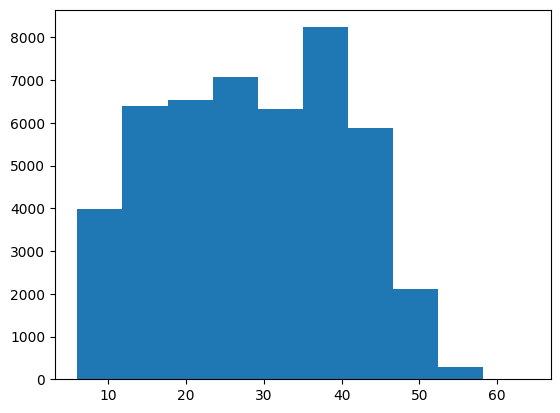

In [5]:
import matplotlib.pyplot as plt

train_lens = [len(i.split()) for i in train_text]
plt.hist(train_lens)


# Tokenize data

In [6]:
import torch

# pad_len = 17
pad_len = 46

tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = pad_len,
    pad_to_max_length = True,
    truncation = True
)

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = pad_len,
    pad_to_max_length = True,
    truncation = True
)


train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [7]:
from torch.utils.data import TensorDataset, DataLoader

# Tạo TensorDataset cho tập huấn luyện
train_dataset = TensorDataset(train_seq, train_mask, train_y)

# Tạo DataLoader cho tập huấn luyện
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Tạo TensorDataset cho tập validation
val_dataset = TensorDataset(val_seq, val_mask, val_y)

# Tạo DataLoader cho tập validation
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)


# Đóng băng các lớp đã được pretrained

In [8]:
for param in bert.parameters():
    param.requires_grad = False

# Định nghĩa các layers mới cho model

In [9]:
import torch.nn as nn
import torch.nn.functional as F
class BERT_architecture(nn.Module):

    def __init__(self, bert):

      super(BERT_architecture, self).__init__()

      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.2)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,3)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

# Cài đặt optimize and Loss

In [10]:
from torch.optim import AdamW
import torch.nn.functional as F
model = BERT_architecture(bert)
optimizer = AdamW(model.parameters(),lr = 1e-3)  # learning rate
criterion = F.cross_entropy

# Change learning rate

In [ ]:
optimizer = AdamW(model.parameters(),lr = 1e-4)  # learning rate

# Change device

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)
model.to(device)

cuda


BERT_architecture(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# Training Function

In [12]:
def count_correct(preds, labels):
  pred = torch.Tensor(preds.argmax(1))
  total_correct = (pred == labels).type(torch.float).sum().item()
  accuracy = total_correct/len(labels)
  return accuracy

In [13]:
from sklearn.metrics import f1_score

def calculate_f1_score(preds, labels):
    # Chuyển đổi các giá trị softmax thành các nhãn dự đoán
    pred = torch.Tensor(preds.argmax(1))

    # Chuyển đổi các tensor thành các numpy array nếu cần
    pred = pred.numpy()
    labels1 = labels.detach().cpu().numpy()

    # Tính F1-score
    f1 = f1_score(labels1, pred, average='weighted')

    return f1


In [14]:
import math
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [15]:
def train(epochs):

  model.train()
  total_avg_loss=[]
  start = time.time()
  total_total_loss = []
  for i in range(epochs):
    total_loss, total_accuracy = 0, 0
    print(f"Epoch {i+1}\n-------------------------------{timeSince(start)}")
    # empty list to save model predictions
    total_preds=[]
    total_accuracy = 0
    total_f1_score = 0
    # iterate over batches
    for step,batch in enumerate(train_dataloader):

      # print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
      # print(f"{timeSince(start)}")


      # progress update after every 50 batches.

      # push the batch to gpu
      batch = [r.to(device) for r in batch]

      sent_id, mask, labels = batch

      # clear previously calculated gradients
      model.zero_grad()

      # get model predictions for the current batch
      preds = model(sent_id, mask)

      # compute the loss between actual and predicted values
      loss = criterion(preds, labels)
      total_total_loss.append(loss.item())
      # if step % 500 == 0 and not step == 0:
      #   print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))


      # add on to the total loss
      total_loss = total_loss + loss.item()

      # backward pass to calculate the gradients
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # update parameters
      optimizer.step()

      total_accuracy += count_correct(preds, labels)

      # model predictions are stored on GPU. So, push it to CPU
      preds=preds.detach().cpu().numpy()

      total_f1_score += calculate_f1_score(preds, labels)

      # append the model predictions
      total_preds.append(preds)


    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
    total_avg_loss.append(avg_loss)

    total_accuracy = total_accuracy / len(train_dataloader)
    total_f1_score = total_f1_score / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    total_preds  = np.concatenate(total_preds, axis=0)

    print(f"Test Error: \n Accuracy: {(100*total_accuracy):>0.1f}%, f1 score: {(100*total_f1_score):>0.1f}%, Avg loss: {avg_loss:>8f} \n")

    # a, b, c = evaluate()
    # pred = np.argmax(b, axis = 1)
    # print(classification_report(pred, val_y))

  #returns the loss and predictions
  return total_avg_loss, total_preds, total_total_loss

# Evaluate Function


In [16]:

# function for evaluating the model
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []
  correct_pred = 0
  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:

      # # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = criterion(preds,labels)

      total_loss = total_loss + loss.item()

      correct_pred += count_correct(preds, labels)
      preds = preds.detach().cpu().numpy()


      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)
  total_correct_pred = correct_pred / len(val_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds, total_correct_pred

# Free Frozen All Parameters



In [17]:
for param in model.parameters():
    param.requires_grad = True

# Testing model

In [ ]:
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

from sklearn.metrics import classification_report
pred = np.argmax(preds, axis = 1)
print(classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       0.62      0.01      0.03       370
           1       0.57      0.99      0.72       481

    accuracy                           0.57       851
   macro avg       0.60      0.50      0.37       851
weighted avg       0.59      0.57      0.42       851



# Training Final

In [18]:
summary_total_loss = []

In [20]:

aa, bb, dd = train(5)


Epoch 1
-------------------------------0m 
Test Error:
 Accuracy: 50.3%, f1 score: 34.7%, Avg loss: 1.035887


# Save model

In [ ]:
if not os.path.exists(directory):
    os.makedirs(directory)

torch.save(model.state_dict(), model_path)


# Load Model

In [ ]:
model_path = '/content/drive/MyDrive/DatasetML/Sentiment Analysis/Model/Index2/ShortBertModel.pth'

In [ ]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# Evaluate Final

In [ ]:
a, b, c = evaluate()
print(c, a)


Evaluating...
0.849578373015873 0.4676526008794705


In [ ]:
print(b)

[[-4.8809133e+00 -1.6473355e-02 -4.7388945e+00]
 [-4.3496780e+00 -1.0732024e+00 -4.3823028e-01]
 [-9.2617437e-02 -2.4637094e+00 -5.7020030e+00]
 ...
 [-9.0818414e-03 -4.8067064e+00 -7.0515671e+00]
 [-3.4128537e-03 -5.7941523e+00 -7.9245510e+00]
 [-9.1301557e-03 -4.7961755e+00 -7.0973172e+00]]


In [3]:
from sklearn.metrics import classification_report
pred = np.argmax(b, axis = 1)
print(classification_report(pred, val_y))


              precision    recall  f1-score   support

           0       0.89      0.91      0.90      15335
           1       0.89      0.88      0.88      13492
           2       0.90      0.92      0.91      17971


    accuracy                           0.89      46789
   macro avg       0.89      0.90      0.90      46789
weighted avg       0.89      0.91      0.90      46789


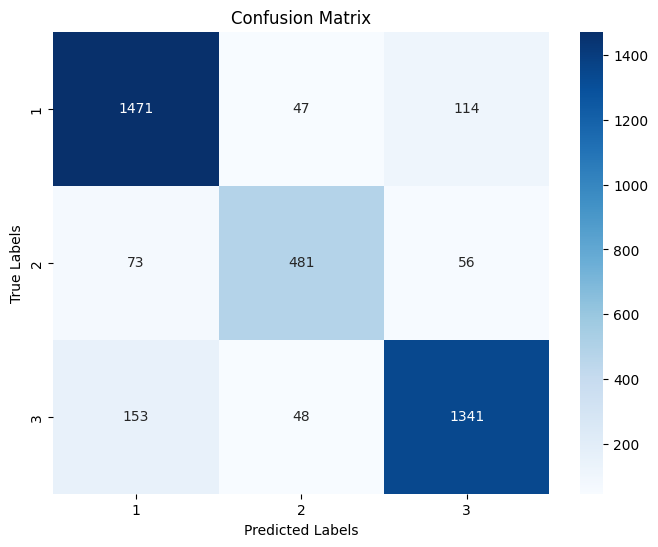

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Example tensor data for labels and predictions
labels = val_y
predictions = np.argmax(b, axis = 1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
